# Astrophysics Laboratory: Data analysis - Stellar clusters
## M71 Data:

### Master bias creation

In [2]:
from helper_functions import masterBiasCreator

dir_bias   = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Calibration_Images/"
dir_saves  = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Calibration_Frames/"
masterBias = masterBiasCreator(dir_bias, False, dir_saves, silent = True)

### Master flat (Red, Green, Blue) creation

In [3]:
from helper_functions import masterFlatCreator

dir_flats       = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Calibration_Images/"
dir_saves       = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Calibration_Frames/"
masterFlatRed   = masterFlatCreator(masterBias, dir_flats, False, dir_saves, "Red", silent = True) # ; print()
masterFlatGreen = masterFlatCreator(masterBias, dir_flats, False, dir_saves, "Green", silent = True) # ; print()
masterFlatBlue  = masterFlatCreator(masterBias, dir_flats, False, dir_saves, "Blue", silent = True)

### Image calibration

In [4]:
from helper_functions import generateCalibratedFrames

dir_lights  = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/All_Images/"
dir_saves   = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Calibrated_Images/"
generateCalibratedFrames(masterBias, masterFlatRed, dir_lights, dir_saves, "Red", silent = True)# ; print()
generateCalibratedFrames(masterBias, masterFlatGreen, dir_lights, dir_saves, "Green", silent = True)# ; print()
generateCalibratedFrames(masterBias, masterFlatBlue, dir_lights, dir_saves, "Blue", silent = True)

### Alignment of individual colours using `astroalign`

In [5]:
from helper_functions import align_colour_frames

light_dir = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Calibrated_Images/"
saves_dir = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Alignment/"

align_colour_frames(light_dir, saves_dir, "Red", silent = True)
align_colour_frames(light_dir, saves_dir, "Green", silent = True)
align_colour_frames(light_dir, saves_dir, "Blue", silent = True)

### Stacking of individual colours

In [6]:
from helper_functions import stack_colour_frames

dir_lights  = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Alignment/"
dir_saves   = dir_lights

_ = stack_colour_frames(dir_lights, dir_saves, 'Red', silent = True, plot_flag = False)
_ = stack_colour_frames(dir_lights, dir_saves, 'Green', silent = True, plot_flag = False)
_ = stack_colour_frames(dir_lights, dir_saves, 'Blue', silent = True, plot_flag = False)

### Alignment of the three resulting stacked light frames (R, G, B)

In [7]:
from helper_functions import align_3_stacked

dir_lights  = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Alignment/"
dir_saves   = dir_lights

align_3_stacked(dir_lights, dir_saves, silent = True)

### Running *'Starfinder'* algorithms

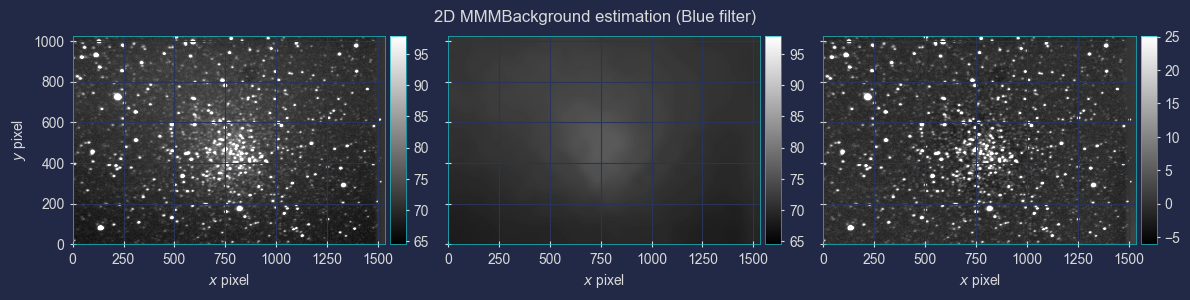

Obtained FWHM values: xfwhm = 7.985213213353921, yfwhm = 9.793069098303468.


Found 467 stars in image (Blue filter).


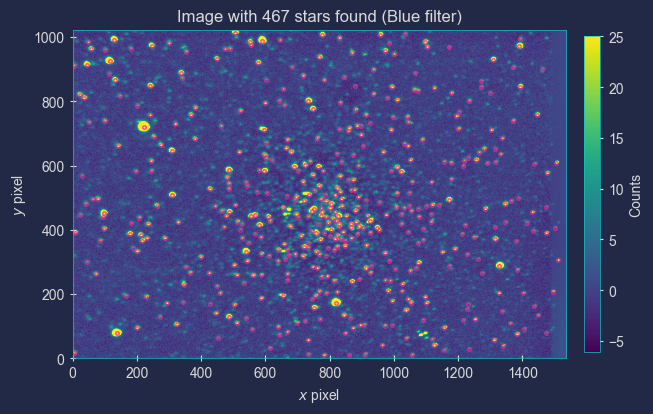

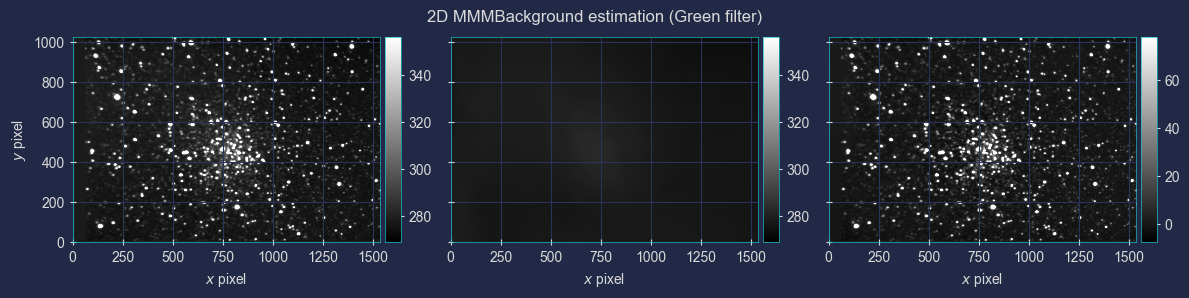

Obtained FWHM values: xfwhm = 7.265027961355647, yfwhm = 7.496241260230734.


Found 742 stars in image (Green filter).


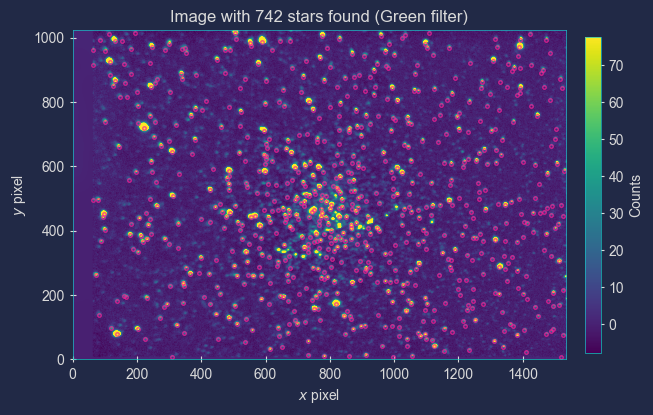

In [1]:
from helper_functions import *

dir_lights       = "C:/Users/afons/Desktop/Universidade/Lab_Astrofisica/Python/Alignment/"
blue_frame_data  = fits.open(dir_lights + "Blue_Stacked_Aligned.fits")[0].data
green_frame_data = fits.open(dir_lights + "Green_Stacked_Aligned.fits")[0].data

blue_table  = CreateStarsTable(blue_frame_data, iterative = False, filter = "Blue", exp_time = 90.0, plot_bkg_flag = True, \
                               plot_stars_flag = True, fit_shape = (9, 9), threshold_sig = 10.0, aperture_radius = 12.0, \
                               grouper_dist = 15.0, model_2D = False, silent = False)

green_table = CreateStarsTable(green_frame_data, iterative = False, filter = "Green", exp_time = 60.0, plot_bkg_flag = True, \
                               plot_stars_flag = True, fit_shape = (9, 9), threshold_sig = 10.0, aperture_radius = 12.0, \
                               grouper_dist = 15.0, model_2D = False, silent = False)

Results - Blue filter:
- 468 stars (Symmetric gaussian model, **not** iterative);
- 478 stars (2D Assymetric gaussian model, **not** iterative).
- 921 stars (Symmetric gaussian model, **iterative**).
- 944 stars (2D Assymetric gaussian model, **iterative**).

TODO:
- Should exclude the ones in the outskirts -> These fits are not meaningful! (I've excluded the ones outside the grid, but not yet those in the `bad` alignment regions.);

Note that this H-R diagram might need to be corrected for the distance later (so we have absolute magnitudes, instead of apparent ones).

416 matches found.


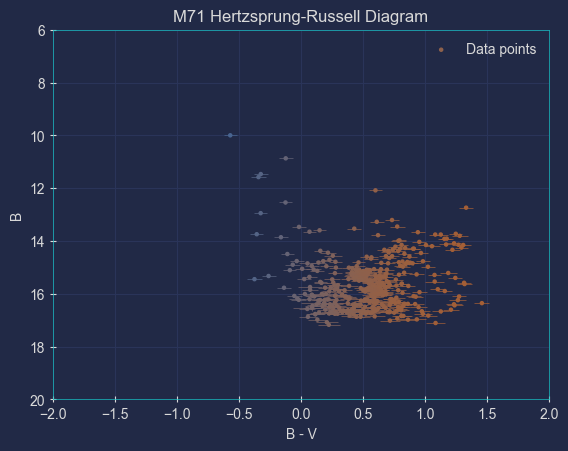

In [4]:
# Currently 'flux_err' is not working for '2DGaussian'. Comment all these lines out if you are using 2D_model = True.

# Sorting metrics.
def get_mag_err(Table):
    return Table['mag_err']
def get_qfit(Table):
    return Table['qfit']

# Selecting only those stars for which 'qfit' < 0.2.
restricted_b = QTable(rows = sorted(blue_table,  key = get_qfit), names = blue_table.colnames)
restricted_g = QTable(rows = sorted(green_table, key = get_qfit), names = green_table.colnames)

restricted_b = restricted_b[restricted_b['qfit']    < 0.25]
restricted_b = restricted_b[restricted_b['mag_err'] < 2] 
                                                         

restricted_g = restricted_g[restricted_g['qfit']    < 0.25]
restricted_g = restricted_g[restricted_g['mag_err'] < 2] # Same here.

from helper_functions import GenerateHR

# In this case, BV should be VR.
BV_List, _, BV_err, V_err = GenerateHR(restricted_b, restricted_g, match_dist = 1.0, silent = True, filters = ('B', 'V'))

# # If you want to plot all the points, before the restrictions, you can do it like this.
# BV_List, _, BV_err, V_err = GenerateHR(green_table, red_table, match_dist = 1.0, silent = True, filters = ('V', 'R'), \
#                                     error_bars_flag = False)

### Trying matching to Gaia catalogue: Still need `astrometry.net` data for this (WCS).

In [6]:
# If you change the functions in 'helper_functions.py' you need to reload them, like this.
import helper_functions
from importlib import reload
reload(helper_functions)
# And then re-import them.

<module 'helper_functions' from 'c:\\Users\\afons\\Desktop\\Universidade\\Lab_Astrofisica\\Python\\helper_functions.py'>

INFO: Query finished. [astroquery.utils.tap.core]
Number of matches with Gaia catalogue = 714.


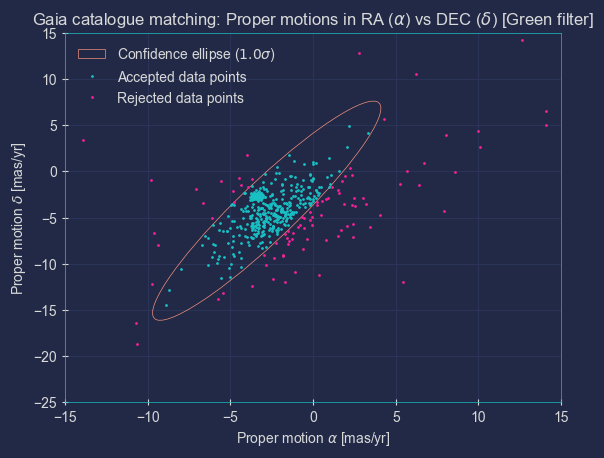

INFO: Query finished. [astroquery.utils.tap.core]
Number of matches with Gaia catalogue = 453.


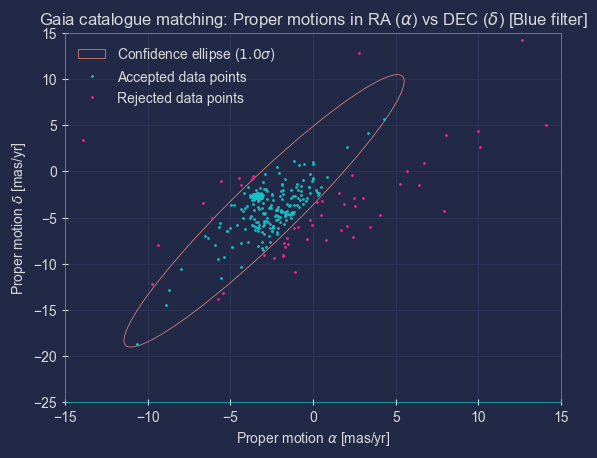

In [5]:
from helper_functions import match_gaia, GaiaEllipseMask_pm

astrometry_file_Green   = "C:/Users/afons/Downloads/new-image_Green.fits" # Green frame
astrometry_file_Blue    = "C:/Users/afons/Downloads/new-image_Blue.fits"  # Blue frame
astrometry_image_Green  = fits.open(astrometry_file_Green)[0]
astrometry_image_Blue   = fits.open(astrometry_file_Blue)[0]

green_table_masked, green_table_unmasked = GaiaEllipseMask_pm(astrometry_image_Green, (298.443, 18.787), \
                                                              green_table, True, silent = False, filter = 'Green', \
                                                              xlim = (-15, 15), ylim = (-25, 15))
blue_table_masked, blue_table_unmasked   = GaiaEllipseMask_pm(astrometry_image_Blue, (298.443, 18.787), \
                                                              blue_table, True, silent = False, filter = 'Blue', \
                                                              xlim = (-15, 15), ylim = (-25, 15))

356 matches found.


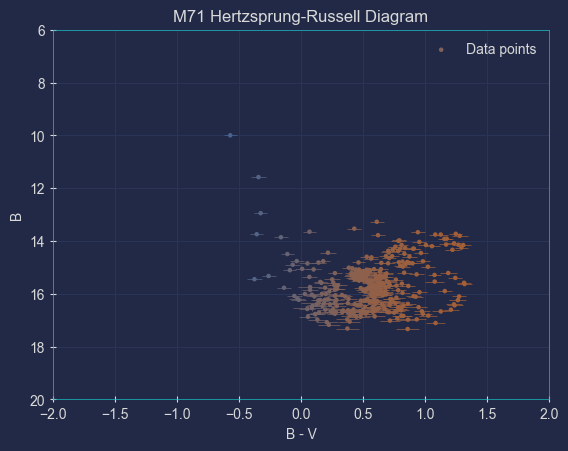

351 matches found.


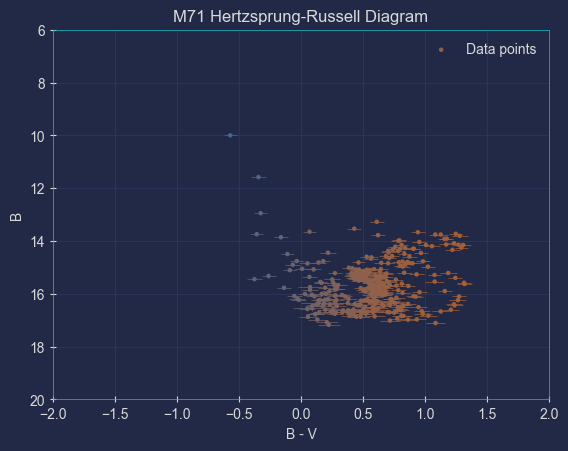

In [19]:
from helper_functions import GenerateHR

BV_List = GenerateHR(blue_table_masked, green_table_masked, match_dist = 1.0, silent = True, \
                     par_flag = True, filters = ('B', 'V'))

# Sorting metrics.
def get_mag_err(Table):
    return Table['mag_err']
def get_qfit(Table):
    return Table['qfit']

# Selecting only those stars for which 'qfit' < 0.2.
restricted_b = QTable(rows = sorted(blue_table_masked, key = get_qfit), names = blue_table_masked.colnames)
restricted_g = QTable(rows = sorted(green_table_masked, key = get_qfit), names = green_table_masked.colnames)

restricted_b = restricted_b[restricted_b['qfit']    < 0.25]
restricted_b = restricted_b[restricted_b['mag_err'] < 2] 
                                                         

restricted_g = restricted_g[restricted_g['qfit']    < 0.25]
restricted_g = restricted_g[restricted_g['mag_err'] < 2] # Same here.

Selected_Stars, par_List, BV_Err, B_Err = \
GenerateHR(restricted_b, restricted_g, match_dist = 1.0, silent = True, \
           par_flag = True, filters = ('B', 'V'))

### Isochrone fitting procedure: (We are neglecting extinction, so far.)

0.3910902369067112 (0, 3)
Best find indices: [i, j] = [0, 3]. Rmsd = 0.3910902369067112.
Best fit model:    age = 10000.0 Myr; distance = 1200 pc.
Literature values: age = 9-10 Gyr; distance = 4000 pc.


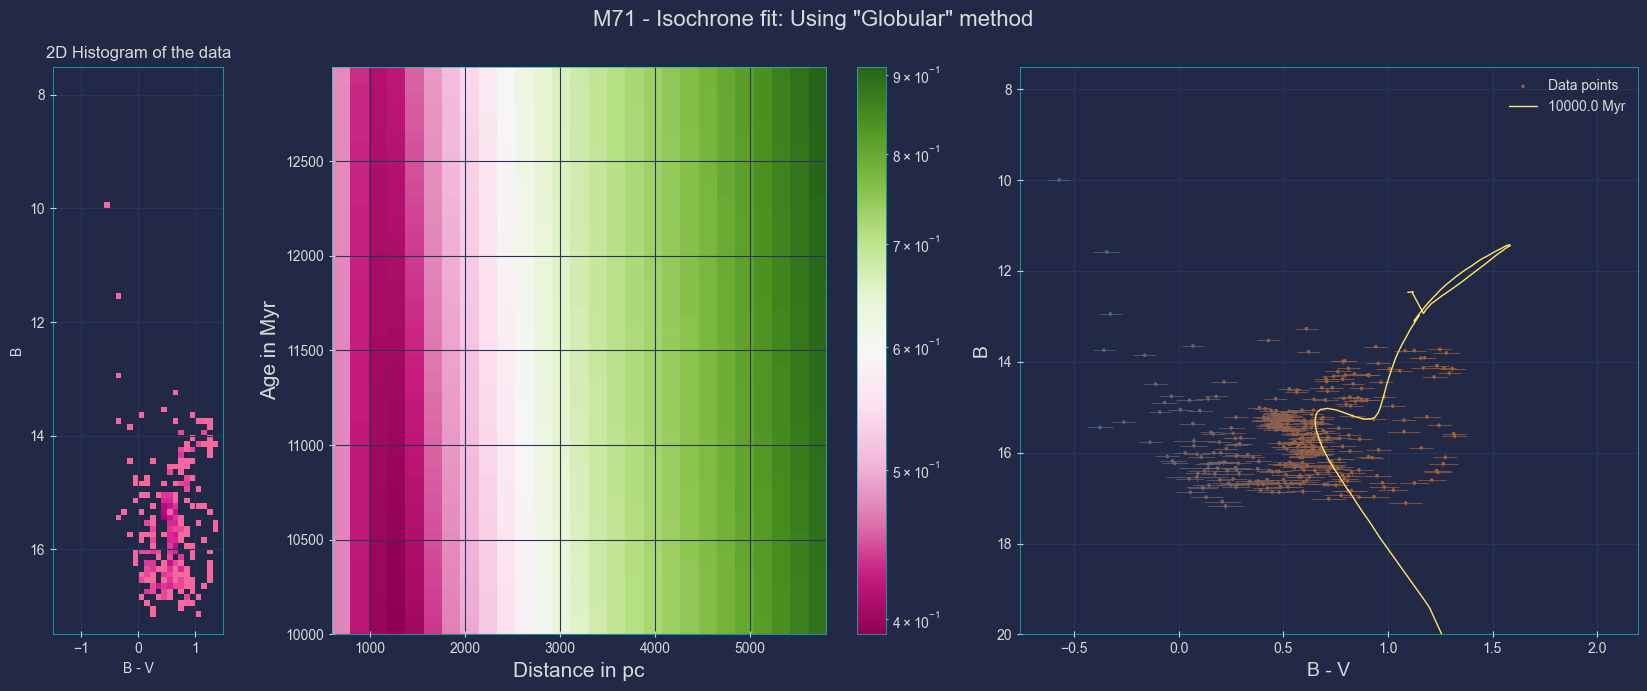

Distance modulus: 10.39591
Distance in pc:   1200.000


In [188]:
from helper_functions import isochrone_fitter

data_x, data_y = [x[0] for x in Selected_Stars], [y[1] for y in Selected_Stars]
isochrone_fitter("./parsec_6Gyr_13Gyr_step50Myr.dat", \
                   data_x, data_y, BV_Err, B_Err, silent = True, object = 'M71', mags = ('B', 'V'),  \
                   dists = (600, 6000, 200), N = 150, mag_lims = (20, 7.5), globular_method = True, \
                   old_flag = True)

# Debugging section

In [ ]:
# Need to go and generate the isochrones again. This time, for older stellar clusters.
# (Since we're working with a globular cluster.)

from helper_functions import *
# Read the models
# Important: Open the model file (in any text editor) and remove the # at the beginning of the line 13 (names of the columns)
# Otherwise python won't know the column names and will call them col1, col2 etc.
isochrones = Table.read('./parsec_6Gyr_13Gyr_step50Myr.dat', format='ascii', guess = False, fast_reader=False)
print(isochrones.columns)

# Let's see which ages we have in the model file
logages = np.unique(isochrones['logAge'])         # Find the unique age entries
ages    = np.unique(10**isochrones['logAge']/1e6) # in Myrs
for logage, age in zip(logages,ages): print(f'Log_Age = {logage:.5f}, Age = {age:.5f} Myrs.') # print all of that

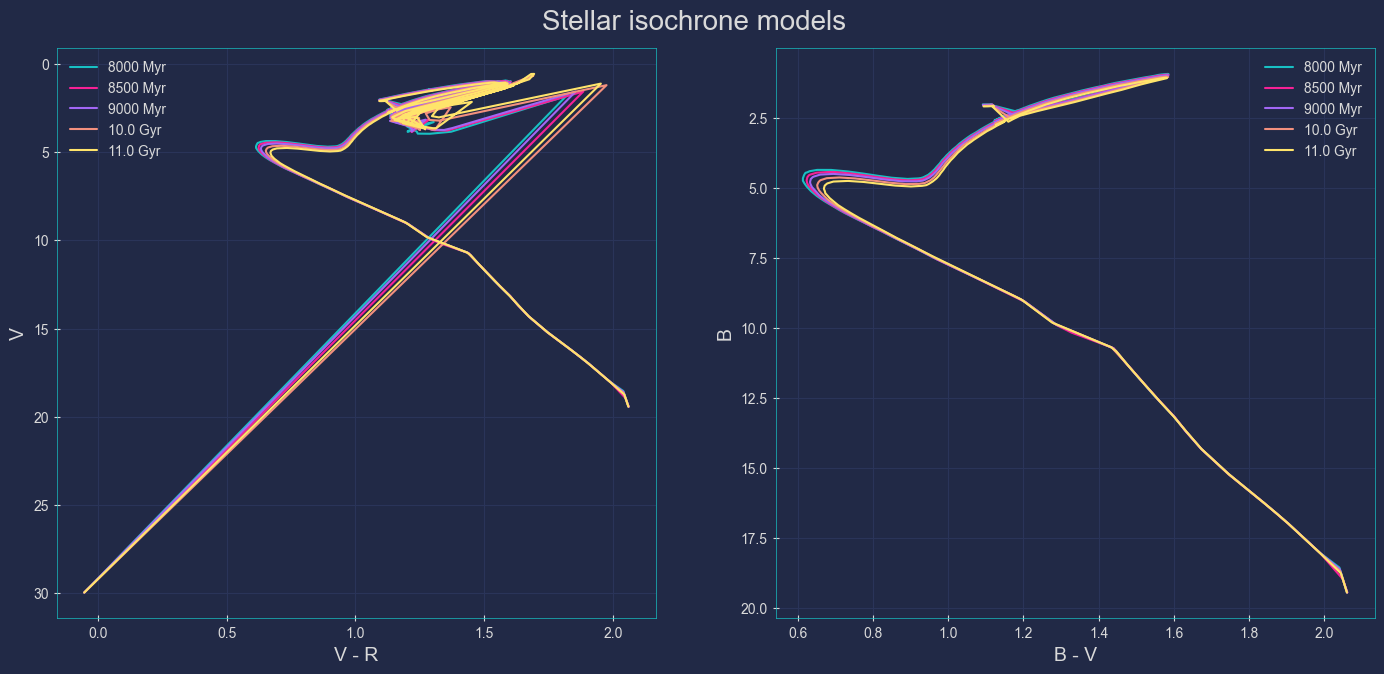

In [67]:
# You can select the isochrone with some particular age
age_1 = isochrones['logAge'] == 9.90309  # 8000 Myrs; False where not this age, True where yes.
age_2 = isochrones['logAge'] == 9.92942  # 8500 Myrs
age_3 = isochrones['logAge'] == 9.95424  # 9000 Myrs
age_4 = isochrones['logAge'] == 10.00000 # 10.0 Gyrs
age_5 = isochrones['logAge'] == 10.04139 # 11 Gyrs

fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
fig.suptitle('Stellar isochrone models', fontsize = 20)
fig.subplots_adjust(top = 0.925)
ax1.plot(isochrones['Bmag'][age_1] - isochrones['Vmag'][age_1], isochrones['Bmag'][age_1], label = '8000 Myr')
ax1.plot(isochrones['Bmag'][age_2] - isochrones['Vmag'][age_2], isochrones['Bmag'][age_2], label = '8500 Myr')
ax1.plot(isochrones['Bmag'][age_3] - isochrones['Vmag'][age_3], isochrones['Bmag'][age_3], label = '9000 Myr')
ax1.plot(isochrones['Bmag'][age_4] - isochrones['Vmag'][age_4], isochrones['Bmag'][age_4], label = '10.0 Gyr')
ax1.plot(isochrones['Bmag'][age_5] - isochrones['Vmag'][age_5], isochrones['Bmag'][age_5], label = '11.0 Gyr')
ax1.invert_yaxis()
ax1.set_xlabel('V - R',fontsize=14)
ax1.set_ylabel('V',fontsize=14)
ax1.legend()

# We can cut off the more evolved stages
N = 150
ax2.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N], label = '8000 Myr')
ax2.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N], label = '8500 Myr')
ax2.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N], label = '9000 Myr')
ax2.plot(isochrones['Bmag'][age_4][0:N] - isochrones['Vmag'][age_4][0:N], isochrones['Bmag'][age_4][0:N], label = '10.0 Gyr')
ax2.plot(isochrones['Bmag'][age_5][0:N] - isochrones['Vmag'][age_5][0:N], isochrones['Bmag'][age_5][0:N], label = '11.0 Gyr')
ax2.invert_yaxis()
ax2.set_xlabel('B - V', fontsize = 14)
ax2.set_ylabel('B', fontsize = 14)
ax2.legend()
plt.show()


### Plot the data & the models together

In [62]:
# Sigmoid scaling function
def colorFader(c1, c2, mix = 0):    # Fade (linear interpolate) from color c1 (at mix = 0) to c2 (mix = 1)
            c1 = np.array(mpl.colors.to_rgb(c1))
            c2 = np.array(mpl.colors.to_rgb(c2))
            return np.array([mpl.colors.to_hex((1 - mix[i]) * c1 + mix[i] * c2) for i in range(len(mix))])

sigmoid = lambda x: 1 / (1 + np.exp(-x))
c1 = '#3266a8' # Blue
c2 = '#a85f32' # Orange

Distance modulus: 13.210965550814457
Distance in pc:   4387.257349408799


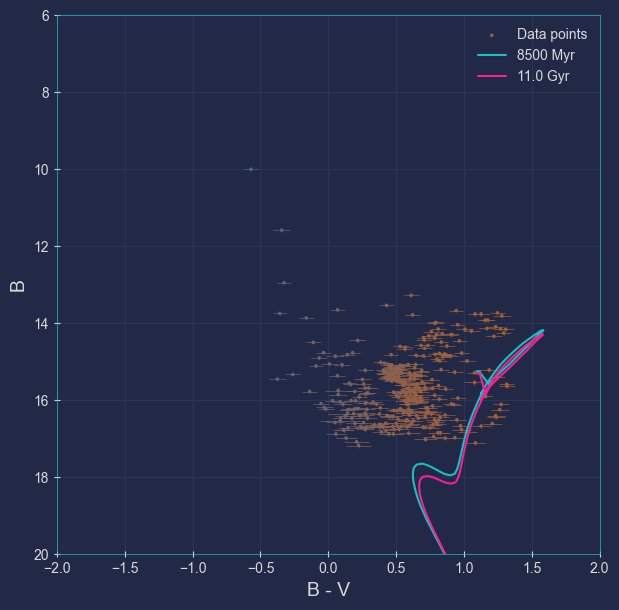

In [68]:
#Let's now plot a model on top of our data, just approximately
data_x, data_y = [x[0] for x in Selected_Stars], [y[1] for y in Selected_Stars]

fig = plt.figure(figsize = (7, 7))
plt.scatter( data_x, data_y, s = 2.5, label = 'Data points', \
             color = colorFader(c1, c2, np.array([sigmoid(x*2.5) for x in data_x])))
plt.errorbar(data_x, data_y, xerr = BV_Err, yerr = B_Err, fmt = 'none', \
             ecolor = colorFader(c1, c2, np.array([sigmoid(x*2.5) for x in data_x])), \
             elinewidth = 0.5)
plt.xlim(-2.0, 2.0)                # This is here for easier comparison with the literature.
plt.ylim(20, 6)
plt.xlabel('B - V', fontsize = 14)
plt.ylabel('B', fontsize = 14)

# Important: isochrones are given in absolute magnitudes, while the data come in apparent
median_parallax = np.nanmedian(par_List)   # Median parallax
dist = 1000/median_parallax                # Important: This distance here is just for demonstration (approximate), we will use a different method o determine it
DM   = 5 * np.log10(dist) - 5              # Distance modulus
print(f'Distance modulus: {DM}')
print(f'Distance in pc:   {dist}')         # Distance in parsecs
plt.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N] + DM, label = '8500 Myr')
plt.plot(isochrones['Bmag'][age_5][0:N] - isochrones['Vmag'][age_5][0:N], isochrones['Bmag'][age_5][0:N] + DM, label = '11.0 Gyr')
plt.legend()
plt.show()

Best find indices: [i, j] = [0, 4]. Rmsd = 0.3572622104030589.
Best fit model:    age = 6000.0 Myr; distance = 1400 pc.
Literature values: age = 9-10 Gyr; distance = 4000 pc.


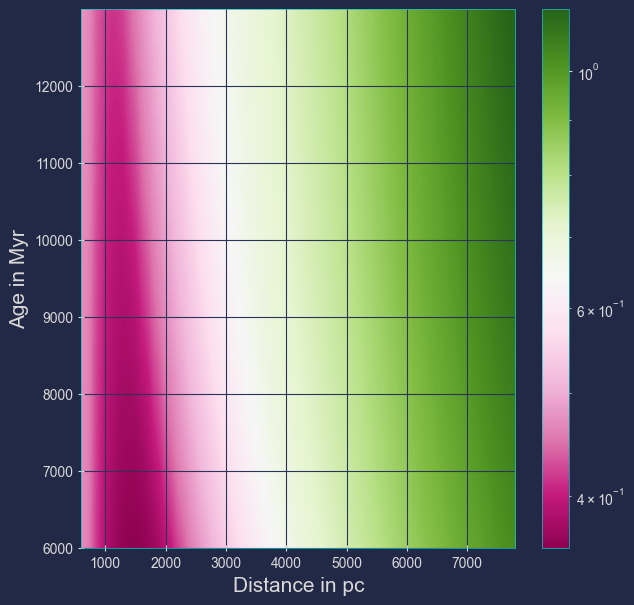

In [69]:
from shapely.geometry import LineString, Point
from matplotlib.colors import LogNorm

# All the ages that we will test
ages = np.unique(isochrones['logAge'])

# Distance
dmin, dmax, step = 600, 8000, 200
distances        = np.arange(dmin, dmax, step) 

# Define an array to save the root-mean-square deviation values
rmsd = np.zeros(shape = (len(ages), len(distances)))
for i in range(len(ages)):
    age = ages[i]
    for j in range(len(distances)):
        
        # Model
        distance  = distances[j]
        DM        = 5 * np.log10(distance) - 5                   # Distance modulus
        isochrone = isochrones[isochrones['logAge'] == age][0:N]
        col_iso   = isochrone['Bmag'] - isochrone['Vmag']        # Color isochrone
        mag_iso   = isochrone['Bmag'] + DM                       # Magnitude isochrone, shifted to the distance of the cluster
        line      = LineString(np.asarray([col_iso, mag_iso]).T) # Representation of the isochrone as a continuous line 

        # Data
        d = np.empty(len(data_x))
        for k in range(len(data_x)):
            col_data = data_x[k]
            mag_data = data_y[k]
            point    = Point(col_data, mag_data)
            d[k] = point.distance(line) # Shortest distance of the point to the line of the isochrone
        # d = np.ma.masked_invalid(d)
        rmsd[i, j] = np.sqrt(np.nanmean(d**2)) 

fig,ax = plt.subplots(figsize = (7, 7))
pos = ax.imshow(rmsd, cmap = 'PiYG', norm = LogNorm(), origin = 'lower',
              extent = [distances[0], distances[-1], 10**ages[0]/1e6, 10**ages[-1]/1e6], aspect = 'auto', \
              interpolation = 'gaussian')
fig.colorbar(pos, ax = ax) # , format = "%d")

# Find the grid position of the minimum rmsd
minrmsd_pos = np.unravel_index(rmsd.argmin(), rmsd.shape)
print(f'Best find indices: [i, j] = [{minrmsd_pos[0]}, {minrmsd_pos[1]}]. Rmsd = {np.nanmin(rmsd)}.')
print("Best fit model:    age =", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance =', distances[minrmsd_pos[1]], 'pc.')
print("Literature values: age = 9-10 Gyr; distance = 4000 pc.")
best_age  = ages[minrmsd_pos[0]]
best_dist = distances[minrmsd_pos[1]]
plt.xlabel('Distance in pc', fontsize = 15)
plt.ylabel('Age in Myr', fontsize = 15)
plt.show()

Distance modulus: 10.73064
Distance in pc:   1400.000


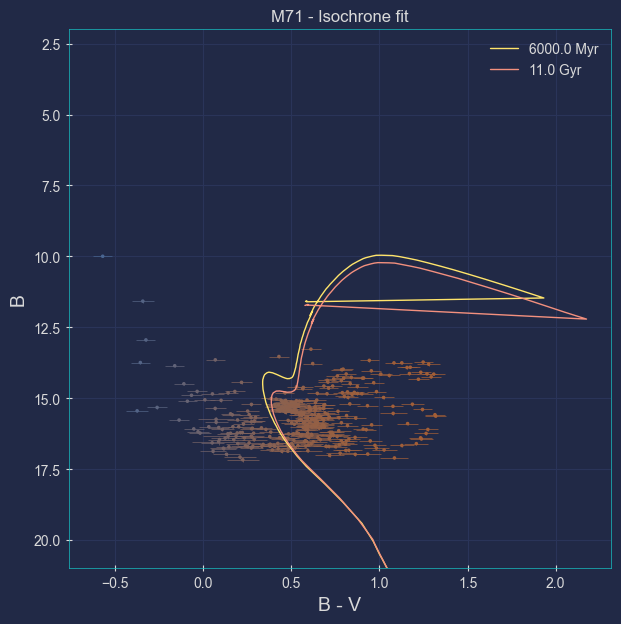

In [70]:
# use PitayaRemix matpltlib style
plt.style.use('https://github.com/kaiuki2000/PitayaRemix/raw/main/PitayaRemix.mplstyle')


#Let's now plot the best-fit model on top of our data
fig = plt.figure(figsize = (7, 7))
plt.scatter( data_x, data_y, s = 2.5, \
             color = colorFader(c1, c2, np.array([sigmoid(x*2.5) for x in data_x])))
plt.errorbar(data_x, data_y, xerr = BV_Err, yerr = B_Err, fmt = 'none', \
             ecolor = colorFader(c1, c2, np.array([sigmoid(x*2.5) for x in data_x])), \
             elinewidth = 0.5)
plt.ylim(21, 2)
plt.xlabel('B - V', fontsize = 14)
plt.ylabel('B', fontsize = 14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
median_parallax = np.nanmedian(par_List)
DM = 5 * np.log10(best_dist) - 5        # Distance modulus
print(f'Distance modulus: {DM:.5f}')
print(f'Distance in pc:   {best_dist:.3f}') # Distance in parsecs

age_1 = isochrones['logAge'] == best_age
plt.plot(isochrones['Vmag'][age_1][0:N] - isochrones['Rmag'][age_1][0:N], isochrones['Vmag'][age_1][0:N] + DM, \
         label = str(np.round(10**best_age/1e6)) + ' Myr', color = 'C4', linewidth = 1.0)
plt.plot(isochrones['Vmag'][age_5][0:N] - isochrones['Rmag'][age_5][0:N], isochrones['Vmag'][age_5][0:N] + DM, \
         label = '11.0 Gyr', color = 'C3', linewidth = 1.0)
plt.title('M71 - Isochrone fit', fontsize = 12)
plt.legend()
plt.show()

### Another approach to isochrone fitting - more suitable for **globular clusters** (like M71): Creating a 2D histogram out of our CMD

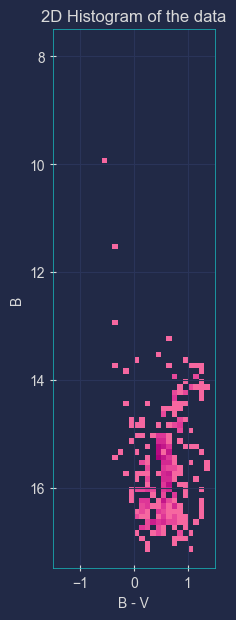

In [104]:
bin_size              = 0.1
min_edge_x,max_edge_x = -1.5 , 1.5
min_edge_y,max_edge_y = 7.5 , 17.5
bin_num_x             = int((max_edge_x-min_edge_x) / bin_size)
bin_num_y             = int((max_edge_y-min_edge_y) / bin_size)
bins_x                = np.linspace(min_edge_x, max_edge_x, bin_num_x + 1)
bins_y                = np.linspace(min_edge_y, max_edge_y, bin_num_y + 1)

col_data = data_x
mag_data = data_y
        
h2d, xedges, yedges   = np.histogram2d(mag_data, col_data, bins = (bins_y, bins_x))
fig, ax               = plt.subplots(figsize = (7, 7))
ax.imshow(h2d, norm   = LogNorm(vmin = 0.01, vmax = 100), extent = [min_edge_x, max_edge_x, min_edge_y, max_edge_y], \
          origin = 'lower')
ax.invert_yaxis()
plt.xlabel('B - V'), plt.ylabel('B')
plt.title('2D Histogram of the data')
plt.show()
# 'bins_x' and 'bins_y' are the edegs of the histogram bins
x = (bins_x + bin_size / 2)[0:-1]

0.3910902369067112 (0, 3)
Best find indices: [i, j] = [0, 3]. Rmsd = 0.3910902369067112.
Best fit model:    age = 10000.0 Myr; distance = 1200 pc.
Literature values: age = 9-10 Gyr; distance = 4000 pc.


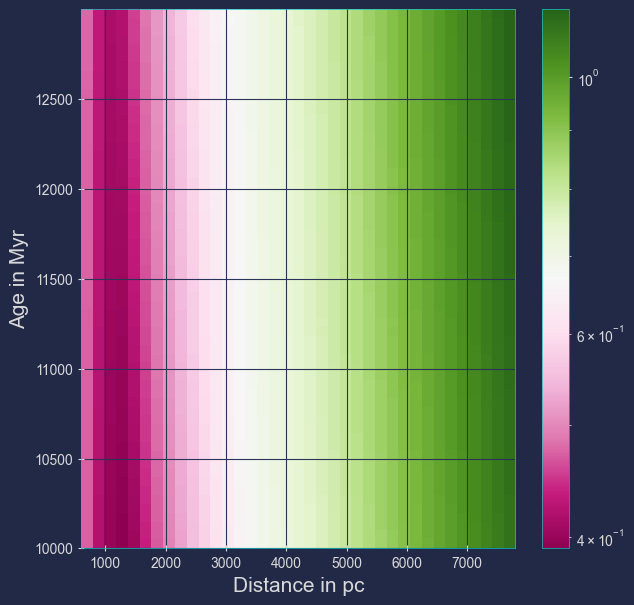

In [105]:
# all the ages that we will test
ages = np.unique(isochrones['logAge'])
ages = ages[ages >= 10]

#distance in pc
dmin, dmax, step = 600, 8000, 200
distances        = np.arange(dmin, dmax, step) 

#values of the histogram for the fitting
x      = (bins_x + bin_size/2)[0:-1] # colors
y      = (bins_y + bin_size/2)[0:-1] # magnitudes
weight = h2d

# define an array to save the root-mean-square deviation values
rmsd = np.zeros(shape = (len(ages), len(distances)))
for i in range(len(ages)):
    age = ages[i]
    for j in range(len(distances)):
        distance = distances[j]
        DM = 5 * np.log10(distance) - 5 # distance modulus
        isochrone = isochrones[isochrones['logAge'] == age][0:N]
        col_iso   = isochrone['Bmag'] - isochrone['Vmag']       # Color isochrone
        mag_iso   = isochrone['Bmag'] + DM                      # Magnitude isochrone, shifted to the distance of the cluster
        line      = LineString(np.asarray([col_iso,mag_iso]).T) # Representation of the isochrone as a continuous line 
            
        d     = np.empty(len(x)*len(y))
        w     = np.empty(len(x)*len(y))
        count = 0
        for k_x in range(len(x)):
            for k_y in range(len(y)):
                col_data = x[k_x]
                mag_data = y[k_y]
                
                point    = Point(col_data, mag_data)
                d[count] = point.distance(line) # Shortest distance of the point to the isochrone
                w[count] = weight[k_y,k_x]
                count    = count + 1
 
        rmsd[i, j] = np.sqrt(np.average(d**2, weights = w)) 
    
fig,ax = plt.subplots(figsize = (7, 7))
pos = ax.imshow(rmsd, cmap = 'PiYG', norm = LogNorm(), origin = 'lower', \
                extent = [distances[0], distances[-1], 10**ages[0]/1e6, 10**ages[-1]/1e6], aspect = 'auto')
fig.colorbar(pos, ax = ax) # , format= "%d")

# Find the grid position of the minimum rmsd
minrmsd_pos = np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd), minrmsd_pos)
print(f'Best find indices: [i, j] = [{minrmsd_pos[0]}, {minrmsd_pos[1]}]. Rmsd = {np.nanmin(rmsd)}.')
print("Best fit model:    age =", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance =', distances[minrmsd_pos[1]], 'pc.')
print("Literature values: age = 9-10 Gyr; distance = 4000 pc.")
best_age  = ages[minrmsd_pos[0]]
best_dist = distances[minrmsd_pos[1]]
plt.xlabel('Distance in pc', fontsize = 15)
plt.ylabel('Age in Myr', fontsize = 15)
plt.show()

Distance modulus: 10.39591
Distance in pc:   1200.000


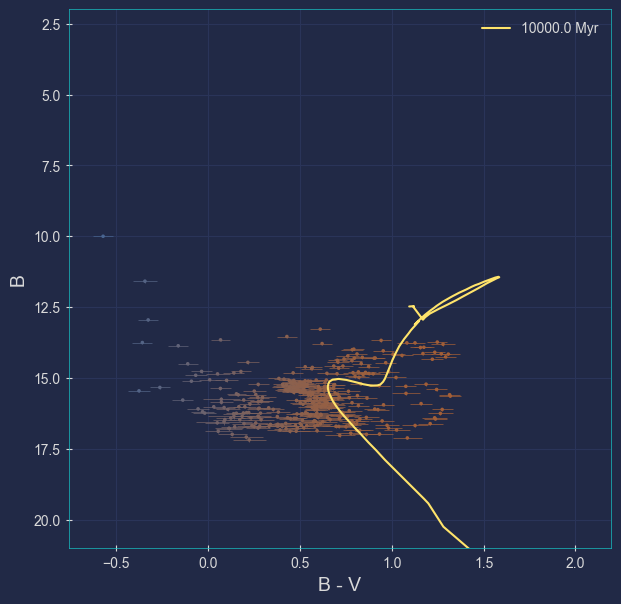

In [109]:
#Let's now plot the best-fit model on top of our data
fig = plt.figure(figsize = (7, 7))
plt.scatter( data_x, data_y, s = 2.5, \
             color = colorFader(c1, c2, np.array([sigmoid(x*2.5) for x in data_x])))
plt.errorbar(data_x, data_y, xerr = BV_Err, yerr = B_Err, fmt = 'none', \
             ecolor = colorFader(c1, c2, np.array([sigmoid(x*2.5) for x in data_x])), \
             elinewidth = 0.5)
plt.ylim(21, 2)
plt.xlabel('B - V', fontsize = 14)
plt.ylabel('B', fontsize = 14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
DM = 5 * np.log10(best_dist) - 5 #distance modulus
print(f'Distance modulus: {DM:.5f}')
print(f'Distance in pc:   {best_dist:.3f}') # Distance in parsecs
age_1 = isochrones['logAge'] == best_age
plt.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N] + DM, label = str(np.round(10**best_age/1e6))+' Myr', color = 'C4')
plt.legend()

### Previous attempts: Gaia matching generated this interesting graph.

In [93]:
# # Plotting the RA vs DEC graph:
# mask_lo, mask_up     = star_dist > mean - std, star_dist < mean + std
# masked_ra            = star_ra[mask_lo & mask_up]
# masked_dec           = star_dec[mask_lo & mask_up]
# plt.plot(masked_ra, masked_dec, 'o', markersize = 2.5, label = 'Accepted data points')
# plt.plot(star_ra[~(mask_lo & mask_up)], star_dec[~(mask_lo & mask_up)], 'o', markersize = 2.5, label = 'Rejected data points')
# plt.title('Gaia catalogue matching: RA vs DEC (Masked)')
# # plt.xlim(-25, 25)
# # plt.ylim(-50, 25)
# plt.xlabel(r'$\alpha$ [deg]')
# plt.ylabel(r'$\delta$ [deg]')
# plt.legend()
# plt.show()

# green_table_masked   = green_table[mask_lo & mask_up]
# green_table_unmasked = green_table[~(mask_lo & mask_up)]